In [34]:
import cv2
import os
import numpy as np
import pickle
import optuna
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import utils

Let us first read the train and test files

In [2]:
# train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
# test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
# train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
# test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
# train_labels = pickle.load(open('train_labels.dat','rb')) 
# test_labels = pickle.load(open('test_labels.dat','rb'))

In [35]:
train_images_filenames = pickle.load(open('../MIT_split/train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('../MIT_split/test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('../MIT_split/train_labels.dat','rb')) 
test_labels = pickle.load(open('../MIT_split/test_labels.dat','rb'))

In [4]:
# import os

# for file in range(len(train_images_filenames)):
#     train_images_filenames[file] = train_images_filenames[file][3:]

# for file in range(len(test_images_filenames)):
#     test_images_filenames[file] = test_images_filenames[file][3:]

### SIFT detector creation
We decide to use SIFT detector because it was the best method we used on C1 Module.

The number of features has been optimized to maximize the accuracy of the method using Optuna. 

/var/folders/sv/8bry6vgs6j7dhy9g_j96yzm00000gn/T/ipykernel_59441/2167873369.py:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


Best Trial: {'nfeatures': 1750}


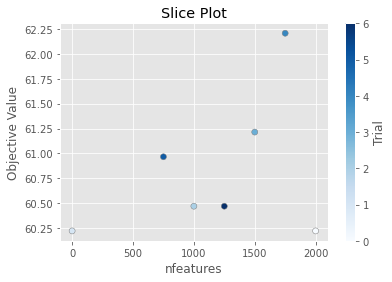

In [36]:
study = optuna.load_study(storage="sqlite:///c3_task1.db", study_name="siftV0")

optuna.visualization.matplotlib.plot_slice(study)


# Get the best hyperparameters
best_trial = study.best_trial
best_params = best_trial.params
print(f"Best Trial: {best_params}")

The highest accuracy = 62,21% has been obtained with a maximum limitation of 1750 local features per image.

In [37]:
sift = cv2.SIFT_create(nfeatures=1750)

### Descriptor Mode Selection
Select if use standard descritptor, dense descriptor or both. Change to True the descriptors you want to use and to False the others.

In [38]:
dense_descriptor = True
standard_descriptor = True

We can also decide to use different strategies.

In [39]:
use_l2_normalize = False
use_standard_scaling = False
use_spatial_pyramid = False

# Whether to load the data from the pickle files or to compute it again
load_from_pickle = True

### Dense SIFT: 
This method has been applied with one hyperparameter to be optimized:
- kpt_size = the size of the keypoint (scale)

Optuna has been used to find the keypoint size that acquires a highest accuracy. These best hyperparameter is:

Best Trial: {'kpt_size': 14}
Best Value: 77.81908302354398


/var/folders/sv/8bry6vgs6j7dhy9g_j96yzm00000gn/T/ipykernel_49624/925824665.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


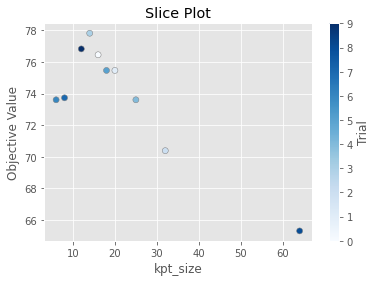

In [105]:
study = optuna.load_study(storage="sqlite:///c3_task1.db", study_name="siftV3")
optuna.visualization.matplotlib.plot_slice(study)

# Get the best hyperparameter
best_trial = study.best_trial
print(f"Best Trial: {best_trial.params}")
print(f"Best Value: {best_trial.value}")

This plot represents the accuracy obtained with different combinations from the grid search realized on Optuna. 

Different steps sizes and scales have been evaluated.


Due to the high amount of time required, it has been stopped before evaluating all the posible combinations.

#### Dense SIFT function:
First all keypoints are obtained using the hyperparameters. Then, the SIFT descriptor is applied on each keypoint and the descriptors are returned.

In [5]:
def dense_sift(img, keypoint_size=14):
    # Compute SIFT descriptors at each grid point
    h, w = img.shape
    margin = int(keypoint_size/2)
    keypoints = [cv2.KeyPoint(x, y, keypoint_size) for y in range(margin, h, keypoint_size) for x in range(margin, w, keypoint_size)]
    _, descriptors = sift.compute(img, keypoints)

    return keypoints, descriptors

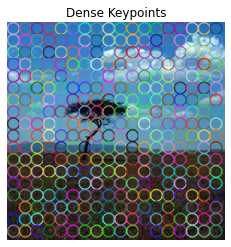

In [8]:
filename = train_images_filenames[1]
image = cv2.imread(filename)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

keypoints, _ = dense_sift(gray, keypoint_size=14)

# Draw keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the result
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Dense Keypoints')
plt.axis('off')
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------

### L2 Normalize descriptors
The purpose of normalizing descriptors, especially in the context of feature matching, is to make the descriptors invariant to scale variations. Normalization can improve the robustness of matching algorithms by making them less sensitive to changes in overall intensity or scale of the features across different images.

In [40]:
def l2_normalize(descriptor):
    if use_l2_normalize:
        norm = np.linalg.norm(descriptor)
        if norm == 0:
            return descriptor
        return descriptor/norm
    return descriptor

### Spatial Pyramid
Spatial pyramid helps capture both local and global spatial information in images by dividing them into multiple levels or regions. This hierarchical representation allows for robust feature matching, accommodating variations in object size and spatial layout. It enhances the performance of computer vision tasks like image recognition.

In [41]:
def compute_histogram(codebook, descriptors):
    if descriptors is None:
        return np.zeros(len(codebook.cluster_centers_))
    labels = codebook.predict(descriptors)
    histogram, _ = np.histogram(labels, bins=range(len(codebook.cluster_centers_) + 1))
    return histogram

def spatial_pyramid_matching(image, codebook, levels):
    histograms = []
    histograms_dense = []
    
    for level in range(levels + 1):
        # Divide the image into a grid
        rows = 2 ** level
        cols = 2 ** level

        # Compute histograms for each grid cell
        for i in range(rows):
            for j in range(cols):
                cell_start_row = int(i * image.shape[0] / rows)
                cell_end_row = int((i + 1) * image.shape[0] / rows)
                cell_start_col = int(j * image.shape[1] / cols)
                cell_end_col = int((j + 1) * image.shape[1] / cols)

                cell_image = image[cell_start_row:cell_end_row, cell_start_col:cell_end_col]

                if standard_descriptor:
                    histograms.append(compute_histogram(codebook, sift.detectAndCompute(cell_image, None)[1]))
                    
                if dense_descriptor:
                    histograms_dense.append(compute_histogram(codebook, dense_sift(cell_image)[1]))

    return np.concatenate(histograms) if histograms else 0, np.concatenate(histograms_dense) if histograms_dense else 0

def get_spatial_pyramid_descriptors(images_filenames, codebook, d_codebook):
    train_descriptors_sp = []
    train_descriptors_sp_dense = []
    for filename in images_filenames:
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)

        if standard_descriptor:
            train_descriptors_sp.append(spatial_pyramid_matching(gray, codebook, 2)[0])
        
        if dense_descriptor:
            train_descriptors_sp_dense.append(spatial_pyramid_matching(gray, d_codebook, 2)[1])
            
    if standard_descriptor:
        train_descriptors_sp = np.vstack(train_descriptors_sp)

    if dense_descriptor:
        train_descriptors_sp_dense = np.vstack(train_descriptors_sp_dense)
            
    return train_descriptors_sp, train_descriptors_sp_dense


------------------------------------------------------------------------------------------------------------------------------------------------

### Descriptors of the Training Dataset
We compute the  descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together for both SIFT and dense SIFT.

In [12]:
def get_descriptors(image_filenames):
    ds = []
    dense_ds = []

    for filename in image_filenames:
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)

        if standard_descriptor:
            _, des = sift.detectAndCompute(gray, None)
            if use_l2_normalize:
                des = l2_normalize(des)
            ds.append(des)

        if dense_descriptor:
            _, d_des = dense_sift(gray)
            if use_l2_normalize:
                d_des = l2_normalize(d_des)
            dense_ds.append(d_des)
        
    descriptors = np.vstack(ds) if standard_descriptor else 0
    dense_descriptors = np.vstack(dense_ds) if dense_descriptor else 0

    scaler, d_scaler = None, None
    if use_standard_scaling:
        if standard_descriptor:
            scaler = StandardScaler().fit(descriptors)
            descriptors = scaler.transform(descriptors)

        if dense_descriptor:
            d_scaler = StandardScaler().fit(dense_descriptors)
            dense_descriptors = d_scaler.transform(dense_descriptors)

    return descriptors, dense_descriptors, scaler, d_scaler, ds, dense_ds

(
    train_descriptors, 
    train_dense_descriptors, 
    scaler, 
    d_scaler, 
    unstacked_train_descriptors, 
    unstacked_train_dense_descriptors
) = get_descriptors(train_images_filenames)

### K-Means clustering
We now compute a k-means clustering on the descriptor space

In [13]:
def kmeans(k, train_descriptors, train_dense_descriptors):
    codebook, d_codebook = None, None
    if standard_descriptor:
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20, compute_labels=False, reassignment_ratio=10**-4, random_state=42)
        codebook.fit(train_descriptors)
        
    if dense_descriptor:
        d_codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20, compute_labels=False, reassignment_ratio=10**-4, random_state=42)
        d_codebook.fit(train_dense_descriptors)
        
    return codebook, d_codebook

k = 192
codebook, d_codebook = kmeans(k, train_descriptors, train_dense_descriptors)

/Users/pauvallespi/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pauvallespi/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Create Training Visual words for BOVW
And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [14]:
def get_train_visual_words(unstacked_train_descriptors, unstacked_train_dense_descriptors, codebook, d_codebook, scaler, d_scaler):
    visual_words, visual_words_dense = None, None
    if standard_descriptor:
        visual_words = np.zeros((len(unstacked_train_descriptors), k), dtype=np.float32)
        for i in range(len(unstacked_train_descriptors)):
            if use_standard_scaling:
                unstacked_train_descriptors[i] = scaler.transform(unstacked_train_descriptors[i])
            words = codebook.predict(unstacked_train_descriptors[i])
            visual_words[i,:] = np.bincount(words, minlength=k)

    if dense_descriptor:
        visual_words_dense = np.zeros((len(unstacked_train_dense_descriptors), k), dtype=np.float32)
        for i in range(len(unstacked_train_dense_descriptors)):
            if use_standard_scaling:
                unstacked_train_dense_descriptors[i] = d_scaler.transform(unstacked_train_dense_descriptors[i])
            d_words = d_codebook.predict(unstacked_train_dense_descriptors[i])
            visual_words_dense[i,:] = np.bincount(d_words, minlength=k)
    
    return visual_words, visual_words_dense

visual_words, visual_words_dense = \
    get_train_visual_words(
        unstacked_train_descriptors,
        unstacked_train_dense_descriptors,
        codebook, 
        d_codebook,
        scaler,
        d_scaler
    )

### Descriptors from Test Dataset
We end up computing the test descriptors and compute the accuracy of both SIFT and dense SIFT models.

In [15]:
def get_test_visual_words(images_filenames, codebook, d_codebook, scaler = None, dense_scaler = None):
    visual_words = np.zeros((len(images_filenames), k), dtype = np.float32)
    visual_words_dense = np.zeros((len(images_filenames), k), dtype = np.float32)

    for i in range(len(images_filenames)):
        filename = images_filenames[i]
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)

        if standard_descriptor:
            _, des = sift.detectAndCompute(gray, None)
            if use_standard_scaling:
                des = scaler.transform(des)
            if use_l2_normalize:
                des = l2_normalize(des)
            words = codebook.predict(des)
            visual_words[i,:] = np.bincount(words, minlength=k)

        if dense_descriptor:
            _, d_des = dense_sift(gray)
            if use_standard_scaling:
                d_des = dense_scaler.transform(d_des)
            if use_l2_normalize:
                d_des = l2_normalize(d_des)
            dense_words = d_codebook.predict(d_des)
            visual_words_dense[i,:] = np.bincount(dense_words, minlength=k)
    
    return visual_words, visual_words_dense

visual_words_test, visual_words_dense_test = \
    get_test_visual_words(test_images_filenames, codebook, d_codebook, scaler, d_scaler)

Store the results so we don't have to load them all the time.

In [42]:
basic_folder = "pickles/basic"
os.makedirs(basic_folder, exist_ok=True)

if load_from_pickle:
    visual_words = pickle.load(open(f'{basic_folder}/visual_words.dat', 'rb'))
    visual_words_dense = pickle.load(open(f'{basic_folder}/visual_words_dense.dat', 'rb'))
    visual_words_test = pickle.load(open(f'{basic_folder}/visual_words_test.dat', 'rb'))
    visual_words_dense_test = pickle.load(open(f'{basic_folder}/visual_words_dense_test.dat', 'rb'))
else:
    pickle.dump(visual_words, open(f'{basic_folder}/visual_words.dat', 'wb'))
    pickle.dump(visual_words_dense, open(f'{basic_folder}/visual_words_dense.dat', 'wb'))
    pickle.dump(visual_words_test, open(f'{basic_folder}/visual_words_test.dat', 'wb'))
    pickle.dump(visual_words_dense_test, open(f'{basic_folder}/visual_words_dense_test.dat', 'wb'))

------------------------------------------------------------------------------------------------------------------------------------------------

### Experimentation
This section is just for testing purposes. In here, we can store different values for different experiments for later use.

In case we want to try with standard scaling.

In [16]:
use_standard_scaling = True
(
    train_descriptors_std_scaling, 
    train_dense_descriptors_std_scaling, 
    scaler, 
    d_scaler, 
    unstacked_train_descriptors_std_scaling, 
    unstacked_train_dense_descriptors_std_scaling
) = get_descriptors(train_images_filenames)

codebook_std_scaling, d_codebook_std_scaling = kmeans(k, train_descriptors_std_scaling, train_dense_descriptors_std_scaling)

(visual_words_std_scaling, visual_words_dense_std_scaling) = \
    get_train_visual_words(
        unstacked_train_descriptors_std_scaling, 
        unstacked_train_dense_descriptors_std_scaling, 
        codebook_std_scaling, 
        d_codebook_std_scaling, 
        scaler, 
        d_scaler
    )

visual_words_test_std_scaling, visual_words_dense_test_std_scaling = \
    get_test_visual_words(test_images_filenames, codebook_std_scaling, d_codebook_std_scaling, scaler, d_scaler)

/Users/pauvallespi/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pauvallespi/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [43]:
std_scaling_folder = "pickles/std_scaling"
os.makedirs(std_scaling_folder, exist_ok=True)

if load_from_pickle:
    visual_words_std_scaling = pickle.load(open(f'{std_scaling_folder}/visual_words_std_scaling.dat', 'rb'))
    visual_words_dense_std_scaling = pickle.load(open(f'{std_scaling_folder}/visual_words_dense_std_scaling.dat', 'rb'))
    visual_words_test_std_scaling = pickle.load(open(f'{std_scaling_folder}/visual_words_test_std_scaling.dat', 'rb'))
    visual_words_dense_test_std_scaling = pickle.load(open(f'{std_scaling_folder}/visual_words_dense_test_std_scaling.dat', 'rb'))
else:
    pickle.dump(visual_words_std_scaling, open(f'{std_scaling_folder}/visual_words_std_scaling.dat', 'wb'))
    pickle.dump(visual_words_dense_std_scaling, open(f'{std_scaling_folder}/visual_words_dense_std_scaling.dat', 'wb'))
    pickle.dump(visual_words_test_std_scaling, open(f'{std_scaling_folder}/visual_words_test_std_scaling.dat', 'wb'))
    pickle.dump(visual_words_dense_test_std_scaling, open(f'{std_scaling_folder}/visual_words_dense_test_std_scaling.dat', 'wb'))

In case we want to try with l2 normalization.

In [17]:
use_l2_normalize = True
(
    train_descriptors_l2, 
    train_dense_descriptors_l2, 
    scaler, 
    d_scaler, 
    unstacked_train_descriptors_l2, 
    unstacked_train_dense_descriptors_l2
) = get_descriptors(train_images_filenames)

codebook_l2, d_codebook_l2 = kmeans(k, train_descriptors_l2, train_dense_descriptors_l2)

visual_words_l2, visual_words_dense_l2 = \
    get_train_visual_words(
        unstacked_train_descriptors_l2, 
        unstacked_train_dense_descriptors_l2, 
        codebook_l2, 
        d_codebook_l2, 
        scaler, 
        d_scaler
    )

visual_words_test_l2, visual_words_dense_test_l2 = \
    get_test_visual_words(test_images_filenames, codebook_l2, d_codebook_l2, scaler, d_scaler)

/Users/pauvallespi/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pauvallespi/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [44]:
l2_norm_folder = "pickles/l2_norm"
os.makedirs(l2_norm_folder, exist_ok=True)

if load_from_pickle:
    visual_words_l2 = pickle.load(open(f'{l2_norm_folder}/visual_words_l2.dat', 'rb'))
    visual_words_dense_l2 = pickle.load(open(f'{l2_norm_folder}/visual_words_dense_l2.dat', 'rb'))
    visual_words_test_l2 = pickle.load(open(f'{l2_norm_folder}/visual_words_test_l2.dat', 'rb'))
    visual_words_dense_test_l2 = pickle.load(open(f'{l2_norm_folder}/visual_words_dense_test_l2.dat', 'rb'))
else:
    pickle.dump(visual_words_l2, open(f'{l2_norm_folder}/visual_words_l2.dat', 'wb'))
    pickle.dump(visual_words_dense_l2, open(f'{l2_norm_folder}/visual_words_dense_l2.dat', 'wb'))
    pickle.dump(visual_words_test_l2, open(f'{l2_norm_folder}/visual_words_test_l2.dat', 'wb'))
    pickle.dump(visual_words_dense_test_l2, open(f'{l2_norm_folder}/visual_words_dense_test_l2.dat', 'wb'))

In case we want to try with spatial pyramid.

In [ ]:
use_spatial_pyramid = True
dense_descriptor = False
train_descriptors_sp, train_descriptors_sp_dense = get_spatial_pyramid_descriptors(train_images_filenames, codebook, d_codebook)
test_descriptors_sp, test_descriptors_sp_dense = get_spatial_pyramid_descriptors(test_images_filenames, codebook, d_codebook)

In [ ]:
spatial_pyramid_folder = "pickles/spatial_pyramid"
os.makedirs(spatial_pyramid_folder, exist_ok=True)

if load_from_pickle:
    train_descriptors_sp = pickle.load(open(f'{spatial_pyramid_folder}/train_descriptors_sp.dat', 'rb'))
    train_descriptors_sp_dense = pickle.load(open(f'{spatial_pyramid_folder}/train_descriptors_sp_dense.dat', 'rb'))
    test_descriptors_sp = pickle.load(open(f'{spatial_pyramid_folder}/test_descriptors_sp.dat', 'rb'))
    test_descriptors_sp_dense = pickle.load(open(f'{spatial_pyramid_folder}/test_descriptors_sp_dense.dat', 'rb'))
else:
    pickle.dump(train_descriptors_sp, open(f'{spatial_pyramid_folder}/train_descriptors_sp.dat', 'wb'))
    pickle.dump(train_descriptors_sp_dense, open(f'{spatial_pyramid_folder}/train_descriptors_sp_dense.dat', 'wb'))
    pickle.dump(test_descriptors_sp, open(f'{spatial_pyramid_folder}/test_descriptors_sp.dat', 'wb'))
    pickle.dump(test_descriptors_sp_dense, open(f'{spatial_pyramid_folder}/test_descriptors_sp_dense.dat', 'wb'))

------------------------------------------------------------------------------------------------------------------------------------------------

### K-NN Classifier
We build a k-nn classifier and train it with the train descriptors

In [16]:
if standard_descriptor:
    knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1, metric='euclidean')
    knn.fit(visual_words, train_labels) 

if dense_descriptor:
    d_knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1, metric='euclidean')
    d_knn.fit(visual_words_dense, train_labels) 

Optuna to test different values for k in kmeans

/var/folders/sv/8bry6vgs6j7dhy9g_j96yzm00000gn/T/ipykernel_49624/1894574369.py:5: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(loaded_study)
[W 2024-01-04 15:29:47,487] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


Best Hyperparameters: {'k_means_clusters': 192, 'knn_distance_metric': 'euclidean', 'knn_neighbors': 10}


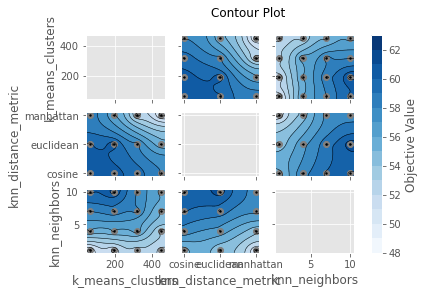

In [17]:
# Load the existing study from the database
loaded_study = optuna.load_study(
    study_name="a11111", storage="sqlite:///hparam.db"
)
optuna.visualization.matplotlib.plot_contour(loaded_study)

# Get the best hyperparameters
best_params = loaded_study.best_params
print("Best Hyperparameters:", best_params)

In [18]:
if standard_descriptor:
    accuracy = 100*knn.score(visual_words_test, test_labels)
    print(f"SIFT accuracy: {accuracy}")

if dense_descriptor:
    dense_accuracy = 100*d_knn.score(visual_words_dense_test, test_labels)
    print(f"Dense SIFT accuracy: {dense_accuracy}")

SIFT accuracy: 61.46220570012392
Dense SIFT accuracy: 77.57125154894672


For categorization the dense SIFT method is more suitable because it takes into account elements of the background that are not relevant for the SIFT method but are still useful to determine which category each image belongs to.

Accuracy:
- SIFT accuracy: 62.20570012391574
- Dense SIFT accuracy: 77.81908302354398

With L2 Normalization:
- SIFT accuracy: 60.09913258983891
- Dense SIFT accuracy: 76.95167286245353

With StandardScaler:
- SIFT accuracy: 61.71003717472119
- Dense SIFT accuracy: 77.94299876084263

#### Dimensionality reduction, with PCA and LDA

We will use this auxiliar function in every model to make it easier to test different models.

In [45]:
def apply_dimensionality_reduction_and_classification(X_train, X_test, train_labels, test_labels, reduction_method, model):
    if reduction_method == 'pca':
        reducer = PCA(n_components=64)
    elif reduction_method == 'lda':
        reducer = LinearDiscriminantAnalysis(n_components=7)
    else:
        raise ValueError("Invalid reduction method. Use 'pca' or 'lda'.")

    X_train_reduced = reducer.fit_transform(X_train, train_labels)
    X_test_reduced = reducer.transform(X_test)

    model.fit(X_train_reduced, train_labels)

    # Make predictions on the test data
    predictions = model.predict(X_test_reduced)

    # Calculate the accuracy
    accuracy = accuracy_score(test_labels, predictions)
    print(f"Accuracy ({reduction_method.upper()}): {accuracy * 100:.2f}%")


##### PCA
PCA aims to maximize the variance in the data. It tends to capture global structures and patterns in the data, but it might not preserve class-specific information well. It might mix information from different classes, leading to reduced discriminative power. That could be the reason for the reduction in accuracy obtained after applying PCA to our problem.

In [20]:
# Apply PCA and KNN for standard descriptors
if standard_descriptor:
    print('PCA and KNN for standard descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words, visual_words_test, train_labels, test_labels, 'pca', model=KNeighborsClassifier(n_neighbors=10,n_jobs=-1,metric='euclidean'))

# Apply PCA and KNN for dense descriptors
if dense_descriptor:
    print('PCA and KNN for dense descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words_dense, visual_words_dense_test, train_labels, test_labels, 'pca', model=KNeighborsClassifier(n_neighbors=10,n_jobs=-1,metric='euclidean'))

PCA and KNN for standard descriptors:
Accuracy (PCA): 63.32%
PCA and KNN for dense descriptors:
Accuracy (PCA): 77.32%


Accuracy:
- SIFT accuracy: 61.957868649318456
- Dense SIFT accuracy: 76.70384138785626

With L2 Normalization:
- SIFT accuracy: 56.25774473358116
- Dense SIFT accuracy: 75.71251548946717

With StandardScaler:
- SIFT accuracy: 63.320941759603464
- Dense SIFT accuracy: 78.56257744733581

##### LDA
LDA considers class information during dimensionality reduction. It aims to maximize the distance between class means while minimizing the spread within each class. This can lead to better separation between classes. Since our data has a clear class structure, LDA is more effective and improves the accuracy to our problem.

In [21]:
# Apply LDA and KNN for standard descriptors
if standard_descriptor:
    print('PCA and KNN for standard descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words, visual_words_test, train_labels, test_labels, 'lda', model=KNeighborsClassifier(n_neighbors=10,n_jobs=-1,metric='euclidean'))

# Apply LDA and KNN for dense descriptors
if dense_descriptor:
    print('PCA and KNN for dense descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words_dense, visual_words_dense_test, train_labels, test_labels, 'lda', model=KNeighborsClassifier(n_neighbors=10,n_jobs=-1,metric='euclidean'))

PCA and KNN for standard descriptors:
Accuracy (LDA): 64.44%
PCA and KNN for dense descriptors:
Accuracy (LDA): 82.53%


Accuracy:
- SIFT accuracy: 66.54275092936803
- Dense SIFT accuracy: 80.04956629491944

With L2 Normalization:
- SIFT accuracy: 62.70136307311029
- Dense SIFT accuracy: 81.04089219330855

With StandardScaler:
- SIFT accuracy: 62.70136307311029
- Dense SIFT accuracy: 83.51920693928129

#### Normalization/Scaler effect


In all three cases the results using the StandardScaler are better than using the L2 normalization. This may be due to the fact that, although SIFT is scale invariant, other algorithms used, such as KNN, are sensitive to the scale of features. StandardScaler helps in making features comparable in magnitude, which can improve the performance of such algorithms. One other option is that tha magnitude of the features is more important for the algorithms used than the direction of the features. L2 normalization is commonly used when the direction of the feature vector is more important than its magnitude. Using the StandardScaler and L2 Norm simultaneously not only does not improve the categorization, but greatly worsens the results.


Dense SIFT might capture more global and structured information from the images, making it less sensitive to normalization and potentially more amenable to dimensionality reduction. For image categorization is more useful and accurate to implement Dense SIFT.



#### Cross validation

In [22]:
if standard_descriptor:
    # Perform cross-validation
    cv_scores_knn = cross_val_score(knn, visual_words, train_labels, cv=5) 

    # Print the cross-validation scores
    print("KNN Cross-Validation Scores:")
    print(cv_scores_knn)
    print(f"Mean Accuracy: {np.mean(cv_scores_knn) * 100:.2f}%")

if dense_descriptor:
    # Perform cross-validation
    cv_scores_knn = cross_val_score(d_knn, visual_words_dense, train_labels, cv=5) 

    # Print the cross-validation scores
    print("KNN Cross-Validation Scores:")
    print(cv_scores_knn)
    print(f"Mean Accuracy: {np.mean(cv_scores_knn) * 100:.2f}%")


KNN Cross-Validation Scores:
[0.47745358 0.56914894 0.59840426 0.53989362 0.53723404]
Mean Accuracy: 54.44%
KNN Cross-Validation Scores:
[0.74535809 0.76595745 0.75797872 0.78989362 0.72606383]
Mean Accuracy: 75.71%


### Experimentation with KNN

In [ ]:
# ...

------------------------------------------------------------------------------------------------------------------------------------------------

### Logistic Regression
We build a logisitc regression classifier and train it with the train descriptors

In [23]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
logistic_reg = LogisticRegression(max_iter=10000)  
dense_logistic_reg = LogisticRegression(max_iter=10000)

# Convert string labels to numerical labels
label_mapping = {label: idx for idx, label in enumerate(np.unique(train_labels))}
train_labels_numeric = np.array([label_mapping[label] for label in train_labels])

# Train the model
logistic_reg.fit(visual_words, train_labels_numeric)
dense_logistic_reg.fit(visual_words_dense, train_labels_numeric)

if standard_descriptor:
    # Make predictions on the test data
    predictions_numeric = logistic_reg.predict(visual_words_test)
    # Assuming you have a label_mapping dictionary that maps numerical labels to string labels
    label_mapping_inverse = {idx: label for label, idx in label_mapping.items()}
    # Convert numerical predictions back to string labels
    predictions = np.array([label_mapping_inverse[idx] for idx in predictions_numeric])
    accuracy = accuracy_score(test_labels, predictions)
    print(f"Accuracy for logistic regression (SIFT): {100*accuracy}")

if dense_descriptor:
    # Make predictions on the test data
    predictions_numeric = dense_logistic_reg.predict(visual_words_dense_test)
    # Assuming you have a label_mapping dictionary that maps numerical labels to string labels
    label_mapping_inverse = {idx: label for label, idx in label_mapping.items()}
    # Convert numerical predictions back to string labels
    predictions = np.array([label_mapping_inverse[idx] for idx in predictions_numeric])
    accuracy = accuracy_score(test_labels, predictions)
    print(f"Accuracy for logistic regression (Dense SIFT): {100*accuracy}")

Accuracy for logistic regression (SIFT): 58.36431226765799
Accuracy for logistic regression (Dense SIFT): 79.5539033457249


#### Dimensionality reduction, with PCA and LDA
##### PCA

In [24]:
# Apply PCA and Logistic Regression for standard descriptors
if standard_descriptor:
    print('PCA and Logistic Regression for standard descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words, visual_words_test, train_labels, test_labels, 'pca', model=LogisticRegression(max_iter=10000))

# Apply PCA and Logistic Regression for dense descriptors
if dense_descriptor:
    print('PCA and Logistic Regression for dense descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words_dense, visual_words_dense_test, train_labels, test_labels, 'pca', model=LogisticRegression(max_iter=10000))

PCA and Logistic Regression for standard descriptors:
Accuracy (PCA): 69.52%
PCA and Logistic Regression for dense descriptors:
Accuracy (PCA): 80.42%


##### LDA

In [25]:
# Apply LDA and Logistic Regression for standard descriptors
if standard_descriptor:
    print('LDA and Logistic Regression for standard descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words, visual_words_test, train_labels, test_labels, 'lda', model=LogisticRegression(max_iter=10000))

# Apply LDA and Logistic Regression for dense descriptors
if dense_descriptor:
    print('LDA and Logistic Regression for dense descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words_dense, visual_words_dense_test, train_labels, test_labels, 'lda', model=LogisticRegression(max_iter=10000))

LDA and Logistic Regression for standard descriptors:
Accuracy (LDA): 64.56%
LDA and Logistic Regression for dense descriptors:
Accuracy (LDA): 84.01%


#### Cross-Validation

In [26]:
if standard_descriptor:
    # Perform cross-validation
    cv_scores_logistic = cross_val_score(logistic_reg, visual_words, train_labels, cv=5)  # You can adjust the number of folds (cv) as needed

    # Print the cross-validation scores
    print("Logistic Regression Cross-Validation Scores:")
    print(cv_scores_logistic)
    print(f"Mean Accuracy: {np.mean(cv_scores_logistic) * 100:.2f}%")

if dense_descriptor:
    # Perform cross-validation
    cv_scores_logistic = cross_val_score(dense_logistic_reg, visual_words_dense, train_labels, cv=5)  # You can adjust the number of folds (cv) as needed

    # Print the cross-validation scores
    print("Logistic Regression Cross-Validation Scores:")
    print(cv_scores_logistic)
    print(f"Mean Accuracy: {np.mean(cv_scores_logistic) * 100:.2f}%")

Logistic Regression Cross-Validation Scores:
[0.50132626 0.53723404 0.59840426 0.61702128 0.56382979]
Mean Accuracy: 56.36%
Logistic Regression Cross-Validation Scores:
[0.74535809 0.7712766  0.77393617 0.78457447 0.72606383]
Mean Accuracy: 76.02%


### Experimentation with Logistic Regression

In [ ]:
# ...

------------------------------------------------------------------------------------------------------------------------------------------------

### Support Vector Machine (SVM)
We build a SVM classifier and train it with the train descriptors. Since we performed a study to get the best parameters for SVM, we can get the parameters from the results obtained use those for the model.

/var/folders/sv/8bry6vgs6j7dhy9g_j96yzm00000gn/T/ipykernel_59441/912349888.py:5: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(loaded_study)
[W 2024-01-04 17:39:23,550] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


Best Hyperparameters: {'C': 0.01, 'kernel': 'linear', 'gamma': 1}


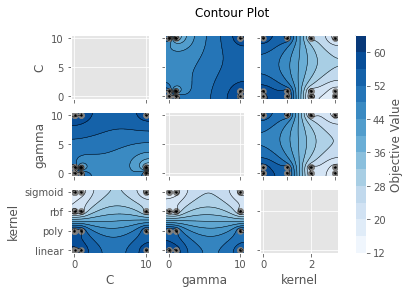

In [10]:
# Load the existing study from the database
loaded_study = optuna.load_study(
    study_name="svm_experiment", storage="sqlite:///svm.db"
)
optuna.visualization.matplotlib.plot_contour(loaded_study)

# Get the best hyperparameters
best_params = loaded_study.best_params
print("Best Hyperparameters:", best_params)

In [11]:
C = best_params['C']
kernel = best_params['kernel']
gamma = best_params['gamma']

if standard_descriptor:
    svm = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
    svm.fit(visual_words, train_labels) 

if dense_descriptor:
    dense_svm = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
    dense_svm.fit(visual_words_dense, train_labels) 

In [12]:
if standard_descriptor:
    accuracy = 100*svm.score(visual_words_test, test_labels)
    print(f"SIFT accuracy: {accuracy}")

if dense_descriptor:
    dense_accuracy = 100*dense_svm.score(visual_words_dense_test, test_labels)
    print(f"Dense SIFT accuracy: {dense_accuracy}")

SIFT accuracy: 65.79925650557621
Dense SIFT accuracy: 81.16480793060718


We obtain a pretty good accuracy with Dense SIFT, but let's try what we obtain when applying PCA and LDA.

#### Dimensionality reduction, with PCA and LDA

##### PCA

In [15]:
# Apply PCA and SVM for standard descriptors
if standard_descriptor:
    print('PCA and SVM for standard descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words, visual_words_test, train_labels, test_labels, 'pca', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))

# Apply PCA and SVM for dense descriptors
if dense_descriptor:
    print('PCA and SVM for dense descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words_dense, visual_words_dense_test, train_labels, test_labels, 'pca', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))

PCA and SVM for standard descriptors:
Accuracy (PCA): 70.14%
PCA and SVM for dense descriptors:
Accuracy (PCA): 80.67%


The results obtained are better for both standard and dense cases, although the latter is slightly better only.

##### LDA

In [16]:
# Apply LDA and SVM for standard descriptors
if standard_descriptor:
    print('LDA and SVM for standard descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words, visual_words_test, train_labels, test_labels, 'lda', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))

# Apply LDA and SVM for dense descriptors
if dense_descriptor:
    print('LDA and SVM for dense descriptors:')
    apply_dimensionality_reduction_and_classification(visual_words_dense, visual_words_dense_test, train_labels, test_labels, 'lda', model=SVC(C=C, kernel=kernel, gamma=gamma, random_state=42))

LDA and SVM for standard descriptors:
Accuracy (LDA): 65.30%
LDA and SVM for dense descriptors:
Accuracy (LDA): 83.89%


The results for LDA and SVM are significantly better than the previous ones with SVM for the case of dense SIFT, however for the standard we can see that we obtain worse results.

##### Cross Validation

In [17]:
if standard_descriptor:
    # Perform cross-validation
    cv_scores_svm = cross_val_score(svm, visual_words, train_labels, cv=5)  # You can adjust the number of folds (cv) as needed

    # Print the cross-validation scores
    print("SVM Cross-Validation Scores:")
    print(cv_scores_svm)
    print(f"Mean Accuracy: {np.mean(cv_scores_svm) * 100:.2f}%")

if dense_descriptor:
    # Perform cross-validation
    dense_cv_scores_svm = cross_val_score(dense_svm, visual_words_dense, train_labels, cv=5)  # You can adjust the number of folds (cv) as needed

    # Print the cross-validation scores
    print("SVM Cross-Validation Scores:")
    print(dense_cv_scores_svm)
    print(f"Mean Accuracy: {np.mean(dense_cv_scores_svm) * 100:.2f}%")

SVM Cross-Validation Scores:
[0.54376658 0.59308511 0.63829787 0.65957447 0.59840426]
Mean Accuracy: 60.66%
SVM Cross-Validation Scores:
[0.76392573 0.77925532 0.78723404 0.83510638 0.76329787]
Mean Accuracy: 78.58%


We see that we obtain worse values in average than the previous experiments with PCA and LDA.

### Experimentation with SVM

First, apply LDA because it yields the best results.

In [49]:
lda = LinearDiscriminantAnalysis()
dense_lda = LinearDiscriminantAnalysis()

visual_words = lda.fit_transform(visual_words, train_labels)
visual_words_test = lda.transform(visual_words_test)
visual_words_dense = dense_lda.fit_transform(visual_words_dense, train_labels)
visual_words_dense_test = dense_lda.transform(visual_words_dense_test)

svm = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
svm.fit(visual_words, train_labels)

dense_svm = SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
dense_svm.fit(visual_words_dense, train_labels)
print("Models loaded!")

Models loaded!


Confusion Matrix (SIFT):


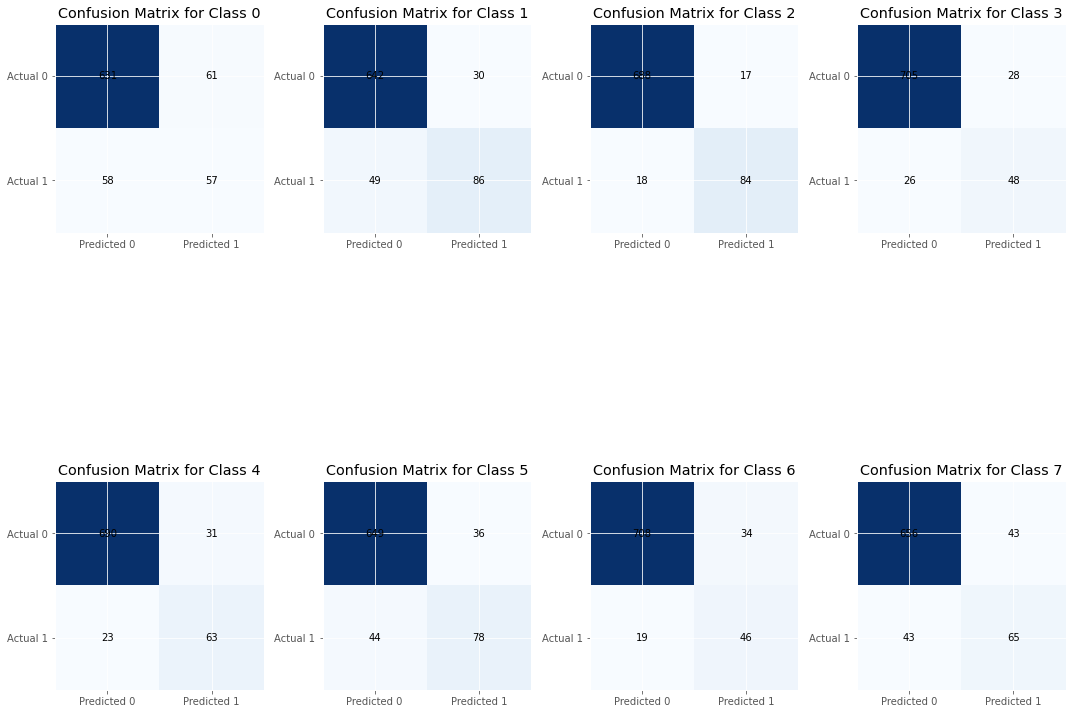

Confusion Matrix (Dense SIFT):


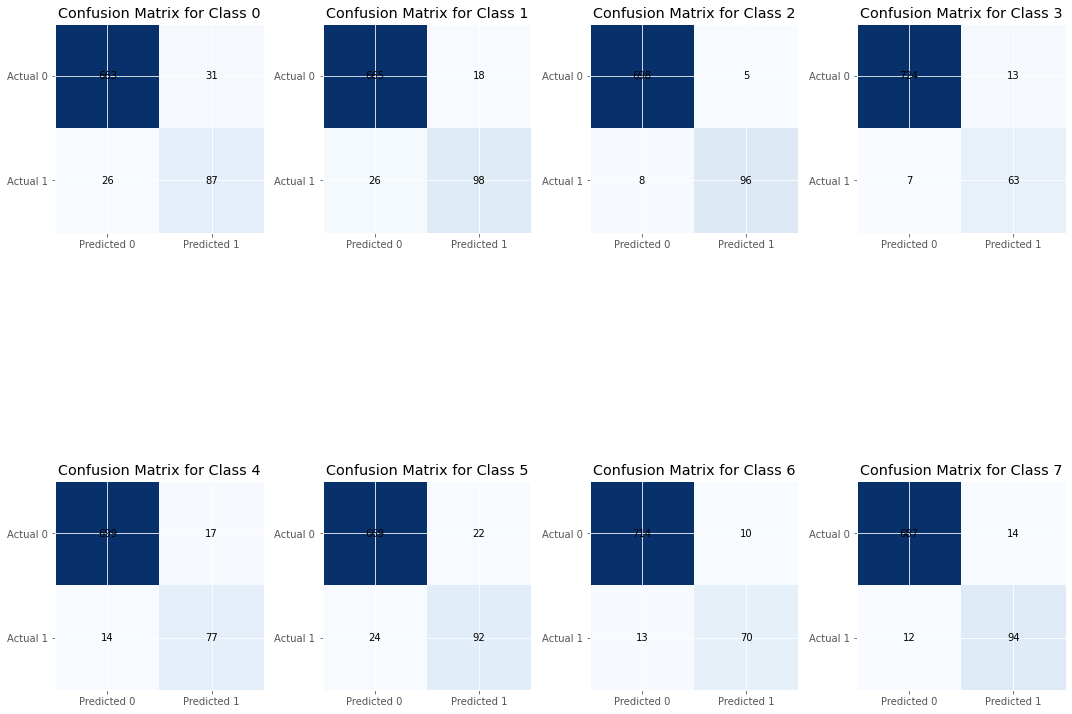

In [50]:
print("Confusion Matrix (SIFT):")
utils.display_multilabel_confusion_matrix(visual_words_test, test_labels, svm)

print("Confusion Matrix (Dense SIFT):")
utils.display_multilabel_confusion_matrix(visual_words_dense_test, test_labels, dense_svm)

In [51]:
report = classification_report(svm.predict(visual_words_test), test_labels)
print("Classification Report (SIFT):\n", report)

Classification Report (SIFT):
               precision    recall  f1-score   support

 Opencountry       0.48      0.50      0.49       115
       coast       0.74      0.64      0.69       135
      forest       0.83      0.82      0.83       102
     highway       0.63      0.65      0.64        74
 inside_city       0.67      0.73      0.70        86
    mountain       0.68      0.64      0.66       122
      street       0.57      0.71      0.63        65
tallbuilding       0.60      0.60      0.60       108

    accuracy                           0.65       807
   macro avg       0.65      0.66      0.65       807
weighted avg       0.66      0.65      0.65       807



In [52]:
report = classification_report(dense_svm.predict(visual_words_dense_test), test_labels)
print("Classification Report (Dense SIFT):\n", report)

Classification Report (Dense SIFT):
               precision    recall  f1-score   support

 Opencountry       0.74      0.77      0.75       113
       coast       0.84      0.79      0.82       124
      forest       0.95      0.92      0.94       104
     highway       0.83      0.90      0.86        70
 inside_city       0.82      0.85      0.83        91
    mountain       0.81      0.79      0.80       116
      street       0.88      0.84      0.86        83
tallbuilding       0.87      0.89      0.88       106

    accuracy                           0.84       807
   macro avg       0.84      0.84      0.84       807
weighted avg       0.84      0.84      0.84       807

